In [16]:
import os

import numpy as np
import pandas as pd


import matplotlib.pyplot as plt

import sklearn.model_selection
from sklearn.cluster import KMeans


import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.predictor import csv_serializer

In [17]:
session = sagemaker.Session()  #Sagemaker Necessities, can be ignored
role = get_execution_role()    #Sagemaker Necessities, can be ignored

In [18]:
df=pd.read_csv('customer_segmentation.csv')      # Reading the dataset and dropping a column that serves no purpose
df.head(20)

,Customer Id,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,Address,DebtIncomeRatio
0,1,41,2,6,19,0.124,1.073,0.0,NBA001,6.3
1,2,47,1,26,100,4.582,8.218,0.0,NBA021,12.8
2,3,33,2,10,57,6.111,5.802,1.0,NBA013,20.9
3,4,29,2,4,19,0.681,0.516,0.0,NBA009,6.3
4,5,47,1,31,253,9.308,8.908,0.0,NBA008,7.2
5,6,40,1,23,81,0.998,7.831,NaN,NBA016,10.9
6,7,38,2,4,56,0.442,0.454,0.0,NBA013,1.6
7,8,42,3,0,64,0.279,3.945,0.0,NBA009,6.6
8,9,26,1,5,18,0.575,2.215,NaN,NBA006,15.5
9,10,47,3,23,115,0.653,3.947,0.0,NBA011,4.0


In [19]:
df= df.drop(['Address', 'Customer Id'], axis=1)
df


,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio
0,41,2,6,19,0.124,1.073,0.0,6.3
1,47,1,26,100,4.582,8.218,0.0,12.8
2,33,2,10,57,6.111,5.802,1.0,20.9
3,29,2,4,19,0.681,0.516,0.0,6.3
4,47,1,31,253,9.308,8.908,0.0,7.2
...,...,...,...,...,...,...,...,...
845,27,1,5,26,0.548,1.220,NaN,6.8
846,28,2,7,34,0.359,2.021,0.0,7.0
847,25,4,0,18,2.802,3.210,1.0,33.4
848,32,1,12,28,0.116,0.696,0.0,2.9


In [20]:
df= df.sample(frac=1).reset_index(drop=True)
df

,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio
0,44,1,19,40,0.344,4.016,NaN,10.9
1,47,1,29,129,20.561,12.076,1.0,25.3
2,51,2,22,120,4.140,4.980,0.0,7.6
3,36,2,7,43,2.649,3.973,0.0,15.4
4,43,1,8,45,0.677,0.808,0.0,3.3
...,...,...,...,...,...,...,...,...
845,30,1,1,27,1.275,2.046,NaN,12.3
846,53,4,7,61,1.875,2.944,0.0,7.9
847,34,2,9,27,0.295,0.164,0.0,1.7
848,47,1,29,169,0.349,3.369,NaN,2.2


In [21]:
df.columns.values  # Just getting an idea of the column titles we have

array(['Age', 'Edu', 'Years Employed', 'Income', 'Card Debt',
       'Other Debt', 'Defaulted', 'DebtIncomeRatio'], dtype=object)

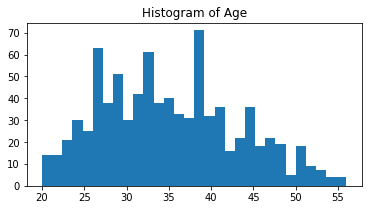

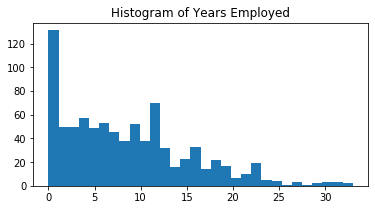

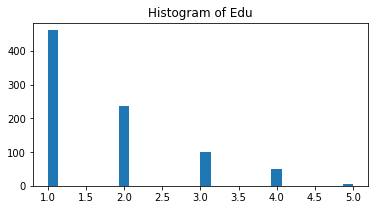

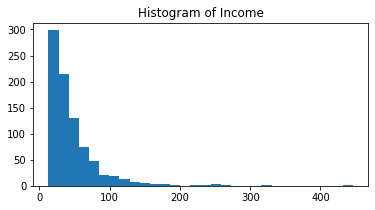

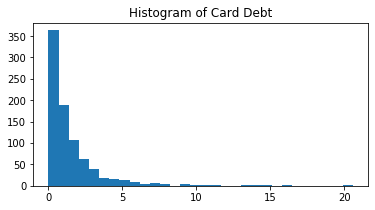

In [22]:
Column_list = ['Age', 'Years Employed', 'Edu', 'Income', 'Card Debt']
n_bins = 30 # can decrease to get a wider bin (or vice versa)

for column_name in Column_list:
    ax=plt.subplots(figsize=(6,3))
    # get data by column_name and display a histogram
    ax = plt.hist(df[column_name], bins=n_bins)
    title="Histogram of " + column_name
    plt.title(title, fontsize=12)
    plt.show()

In [42]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()

dfs=pd.DataFrame(scaler.fit_transform(df.astype(float)))#Applying standardization to our dataset
dfs.columns=df.columns.values   #Making sure we add back the previous column names


In [43]:
prefix = 'kmeans_modeling'
output_path= 's3://{}/{}/output'.format(session.default_bucket(), prefix)

In [44]:
df.mean()

Age                34.860000
Edu                 1.722857
Years Employed      8.388571
Income             45.601429
Card Debt           1.553566
Other Debt          3.058196
Defaulted           0.261429
DebtIncomeRatio    10.260571
dtype: float64

In [45]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

In [46]:
df= clean_dataset(df)

In [47]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df)
    distortions.append(kmeanModel.inertia_)

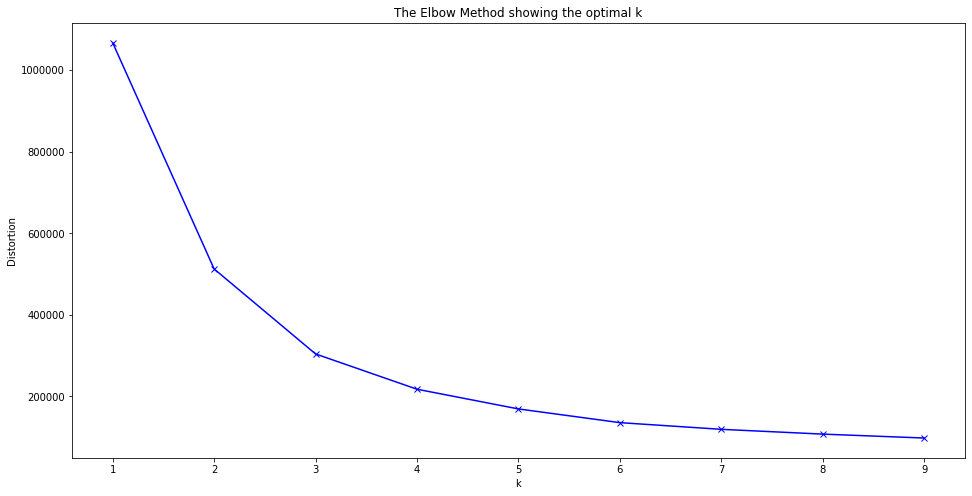

In [48]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [49]:
from sagemaker import KMeans

num_k = 8

kmeans = KMeans(role=role,
              train_instance_count=1,
              train_instance_type='ml.c4.xlarge',
              k=num_k, 
              output_path=output_path)

In [50]:
# convert the transformed dataframe into record_set data
kmeans_train_data_np = df.values.astype('float32')
kmeans_formatted_data = kmeans.record_set(kmeans_train_data_np)

In [51]:
kmeans.fit(kmeans_formatted_data)


'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-07-17 02:14:42 Starting - Starting the training job...
2020-07-17 02:14:44 Starting - Launching requested ML instances......
2020-07-17 02:15:50 Starting - Preparing the instances for training...
2020-07-17 02:16:41 Downloading - Downloading input data.....
2020-07-17 02:17:40 Training - Training image download completed. Training in progress.
2020-07-17 02:17:40 Uploading - Uploading generated training model
2020-07-17 02:17:40 Completed - Training job completed
Docker entrypoint called with argument(s): train
Running default environment configuration script
[07/17/2020 02:17:30 INFO 139965463660352] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u

Training seconds: 59
Billable seconds: 59


In [52]:
kmeans_predictor = kmeans.deploy(initial_instance_count=1,
                                instance_type='ml.t2.medium')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


-----------------!

In [54]:
cluster_info= kmeans_predictor.predict(kmeans_train_data_np)
cluster_info

[label {
   key: "closest_cluster"
   value {
     float32_tensor {
       values: 6.0
     }
   }
 }
 label {
   key: "distance_to_cluster"
   value {
     float32_tensor {
       values: 33.370201110839844
     }
   }
 },
 label {
   key: "closest_cluster"
   value {
     float32_tensor {
       values: 6.0
     }
   }
 }
 label {
   key: "distance_to_cluster"
   value {
     float32_tensor {
       values: 15.344099998474121
     }
   }
 },
 label {
   key: "closest_cluster"
   value {
     float32_tensor {
       values: 3.0
     }
   }
 }
 label {
   key: "distance_to_cluster"
   value {
     float32_tensor {
       values: 6.951351642608643
     }
   }
 },
 label {
   key: "closest_cluster"
   value {
     float32_tensor {
       values: 3.0
     }
   }
 }
 label {
   key: "distance_to_cluster"
   value {
     float32_tensor {
       values: 9.786028861999512
     }
   }
 },
 label {
   key: "closest_cluster"
   value {
     float32_tensor {
       values: 4.0
     }
   }
 }
 lab

In [57]:
# print cluster info for first data point
data_idx = 0

print('index {} is: '.format(data_idx), df.index[data_idx])
print()
print(cluster_info[data_idx])

index 0 is:  1

label {
  key: "closest_cluster"
  value {
    float32_tensor {
      values: 6.0
    }
  }
}
label {
  key: "distance_to_cluster"
  value {
    float32_tensor {
      values: 33.370201110839844
    }
  }
}



In [58]:
cluster_labels = [c.label['closest_cluster'].float32_tensor.values[0] for c in cluster_info]
cluster_labels[0:5]

[6.0, 6.0, 3.0, 3.0, 4.0]

In [59]:
cluster_df = pd.DataFrame(cluster_labels)[0].value_counts()

print(cluster_df)

0.0    133
5.0    132
3.0    124
7.0    108
4.0     89
1.0     58
6.0     41
2.0     15
Name: 0, dtype: int64


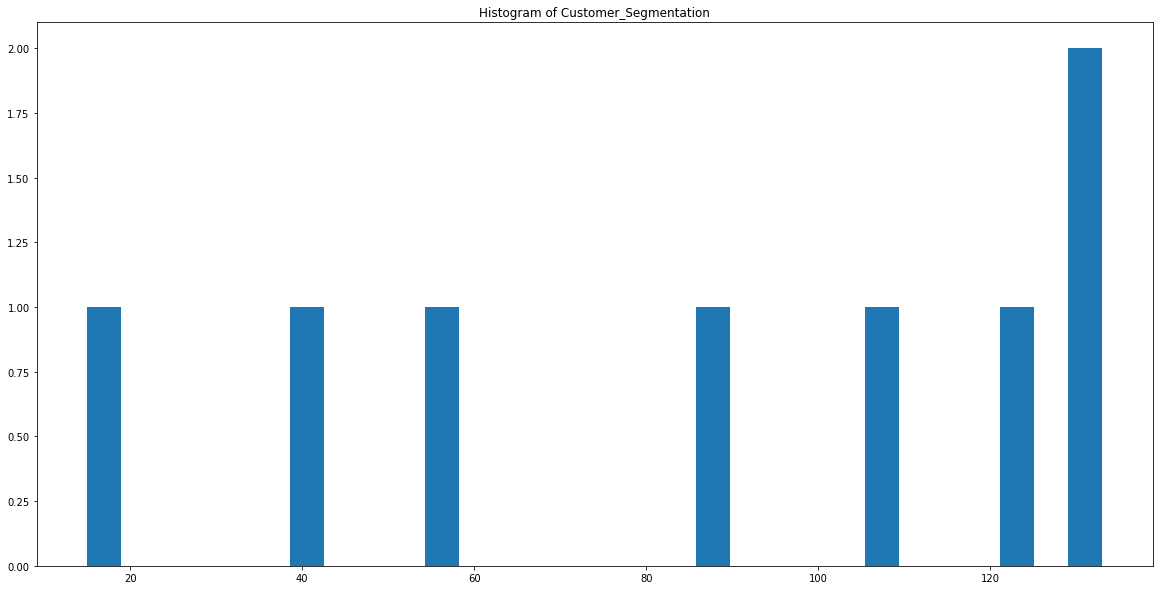

In [66]:
n_bins = 30 # can decrease to get a wider bin (or vice versa)
ax=plt.subplots(figsize=(20,10))
    # get data by column_name and display a histogram
ax = plt.hist(cluster_df, bins=n_bins)
title="Histogram of " + 'Customer_Segmentation'
plt.title(title, fontsize=12)
plt.show()